## TSML-13_HW3_ARIMA

Задание: Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [96]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt

#### Функцию для проведения теста Дики-Фуллера

In [5]:
def test_stationarity(timeseries):
    '''
    Dickey-Fuller Test
    '''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### Функцию вывода коррелограмм

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''
    The function of the output of correlograms
    '''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#### Берем ряд Mean monthly air temperature (Deg. F) Nottingham Castle

In [109]:
series = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

#### 1) Проверка ряда на стационарность
#### 2) Сделаем тест Дики-Фуллера
#### 3) Посмотрим на коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


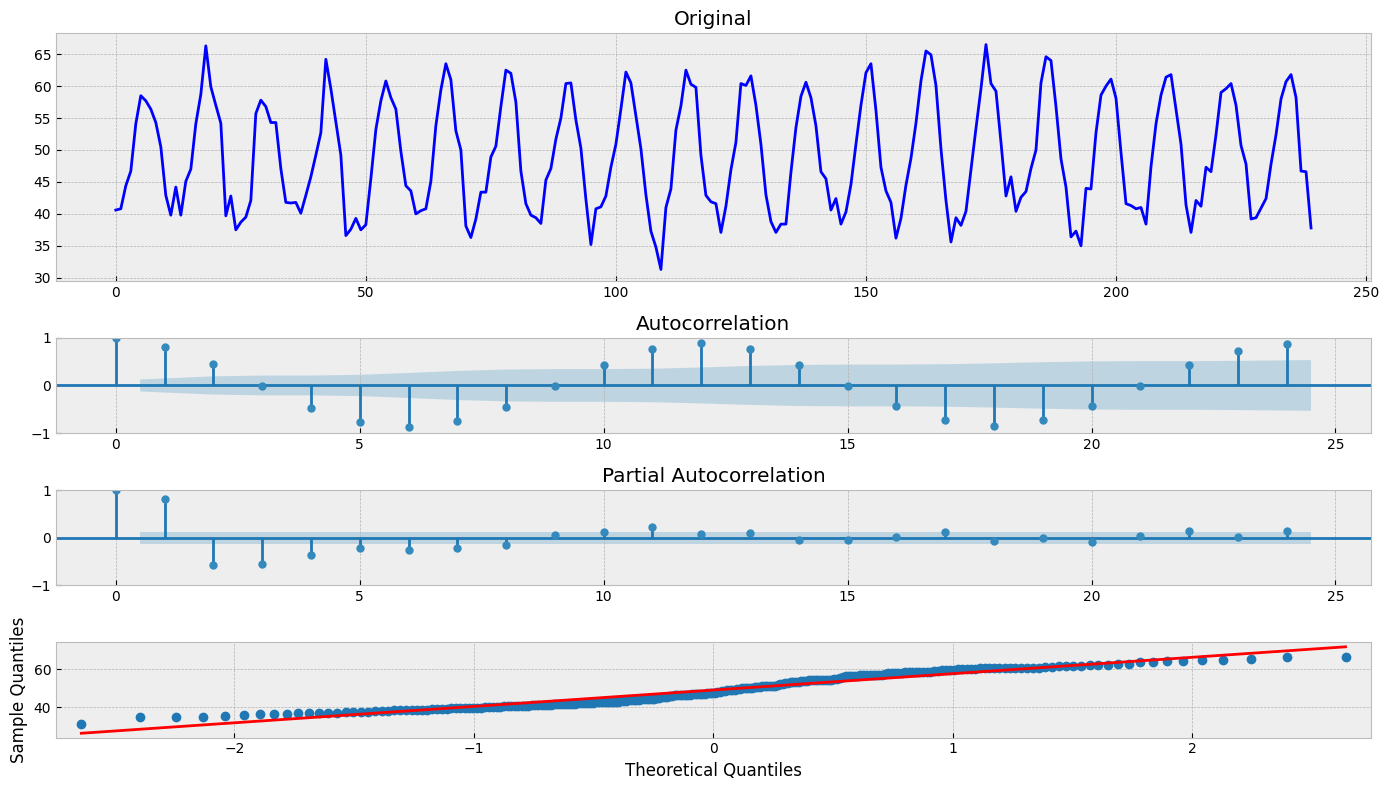

In [110]:
tsplot(series)

#### p-value меньше 0.05
#### Присутствует сезонность
#### Пробуем убрать её преобразованием Бокса-Кокса и дифференцированием с лагом 12 месяцев.

In [111]:
series = boxcox(series, 0)

In [112]:
series = np.diff(series, 12)

#### Повторно проверим преобразованный ряд на стационарность

Results of Dickey-Fuller Test:
Test Statistic                -1.513025e+01
p-value                        7.248952e-28
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


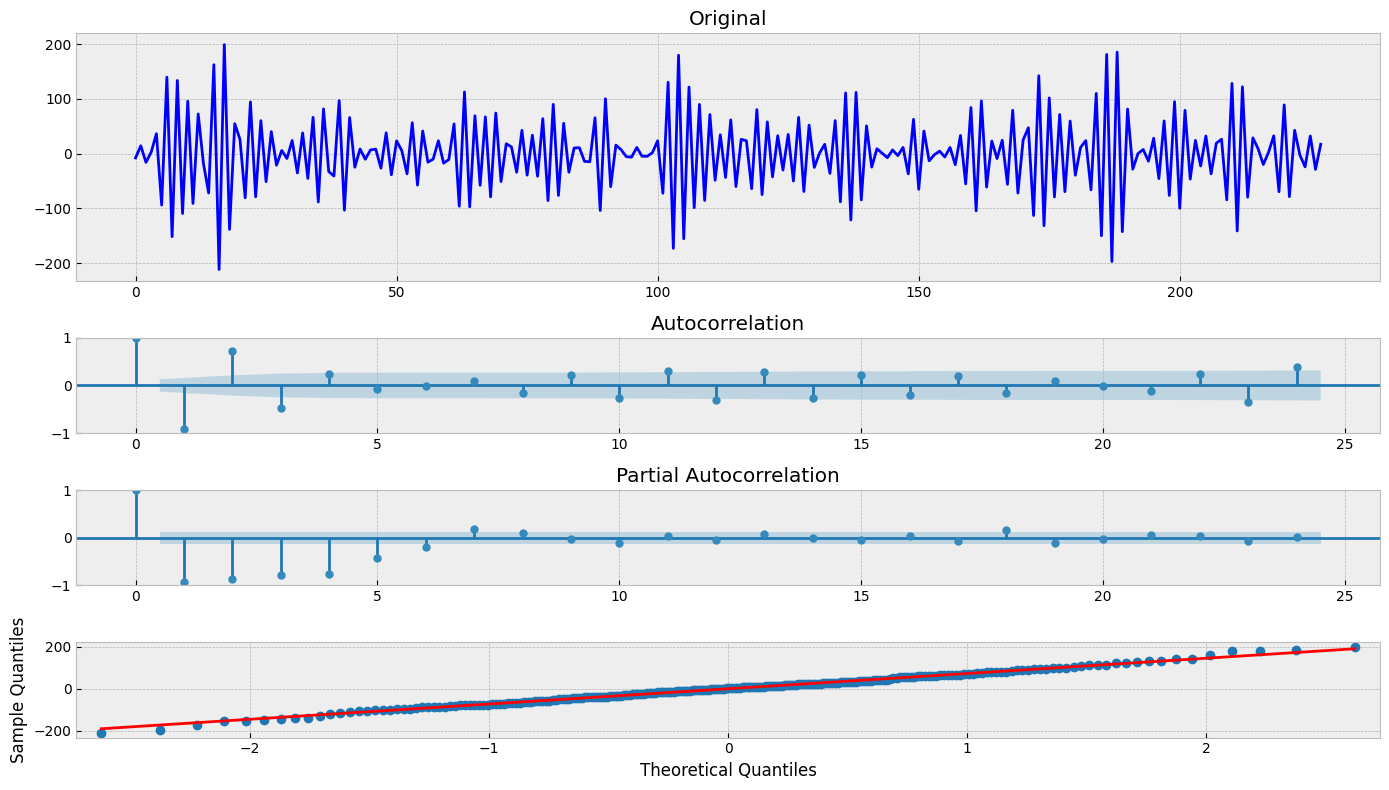

In [113]:
tsplot(series)

#### p-value снизилось почти до нуля
#### Сезонность ушла. 
#### Ряд стал стационарным. 

#### Попробуем построить модель ARIMA на значениях преобразованного ряда.

aic: 601.47476 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                -5.918536e+00
p-value                        2.538670e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


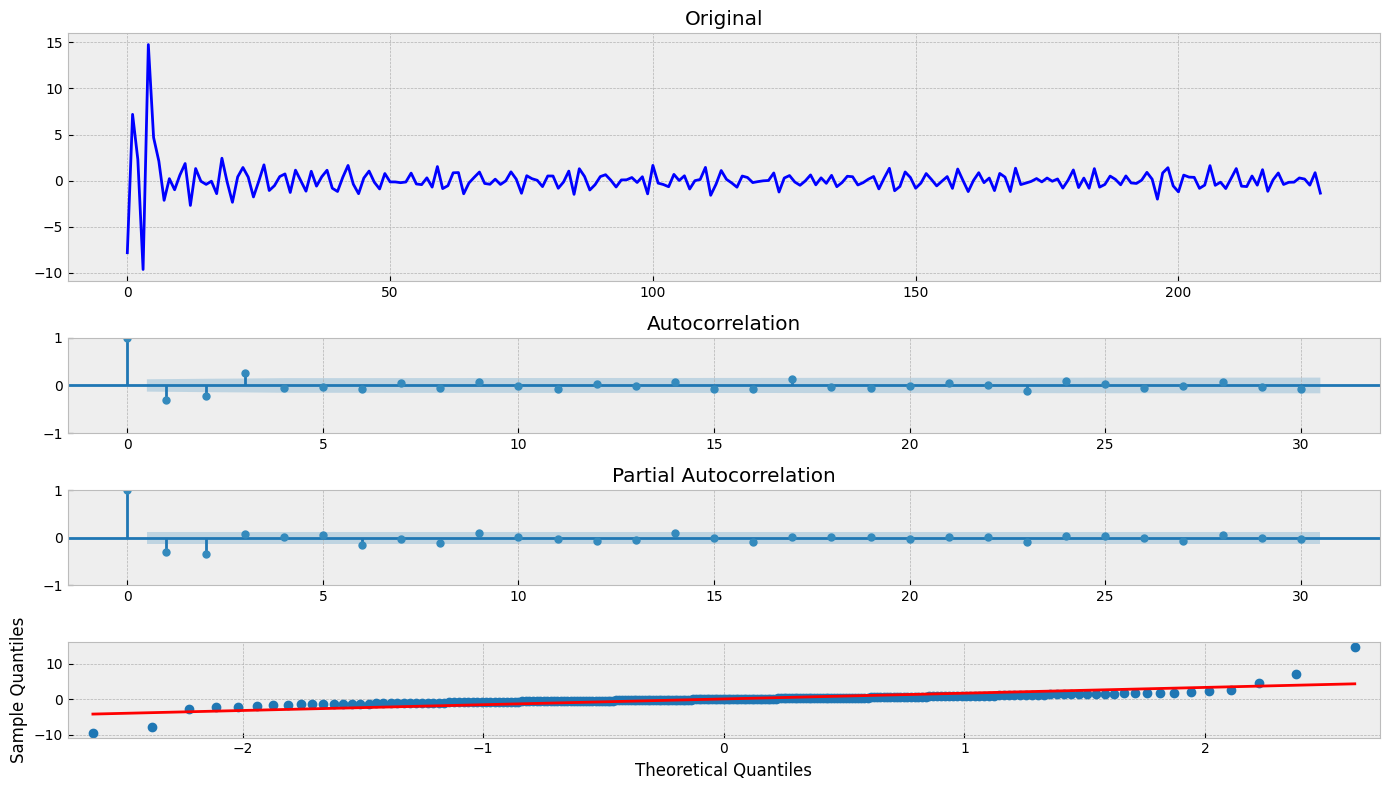

In [121]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                model = sm.tsa.arima.ARIMA(series, order=(i,d,j))
                tmp_mdl = model.fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

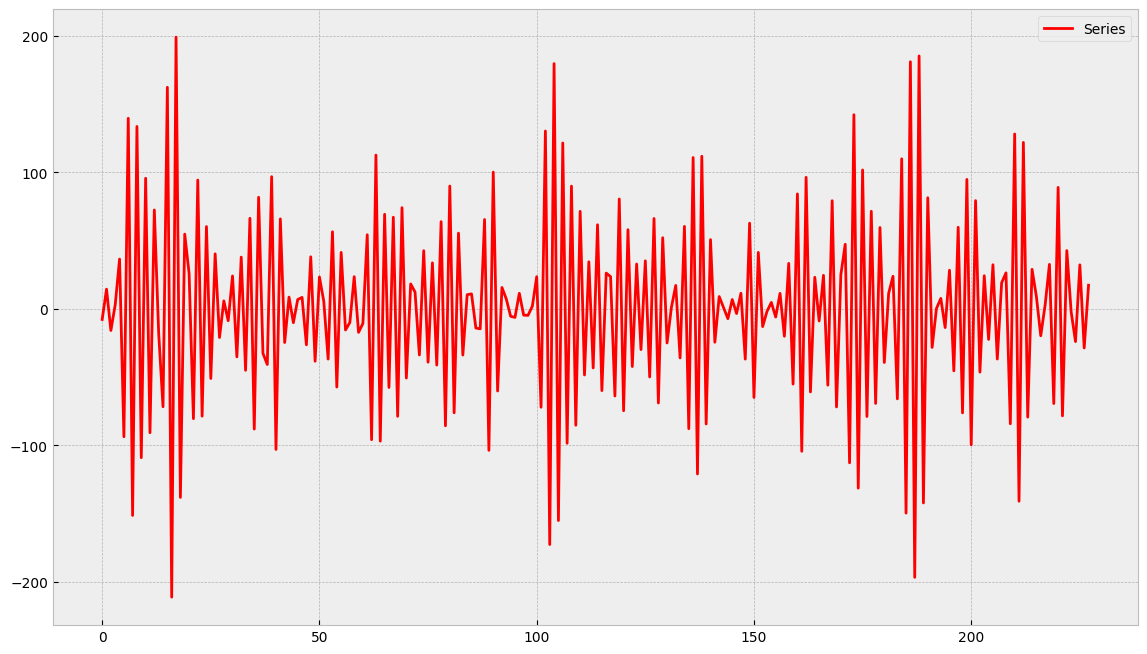

In [125]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

#### Модель ARIMA в данном случае не очень хорошо предсказала значения временного ряда.
#### Модель, по всей видимости, переобучилась на реальных данных. Возможно, так получилось из-за предварительного преобразования ряда в стационарный. 
#### Попробуем обучить модель ARIMA на изначальном (нестационарном) ряде, т.к. в ARIMA заложены механизмы работы именно с нестационарными рядами.

In [126]:
series = pd.read_csv("./data/HW1/mean-monthly-air-temperature-deg.csv")['Deg']

aic: 1136.11316 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                  -5.624780
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


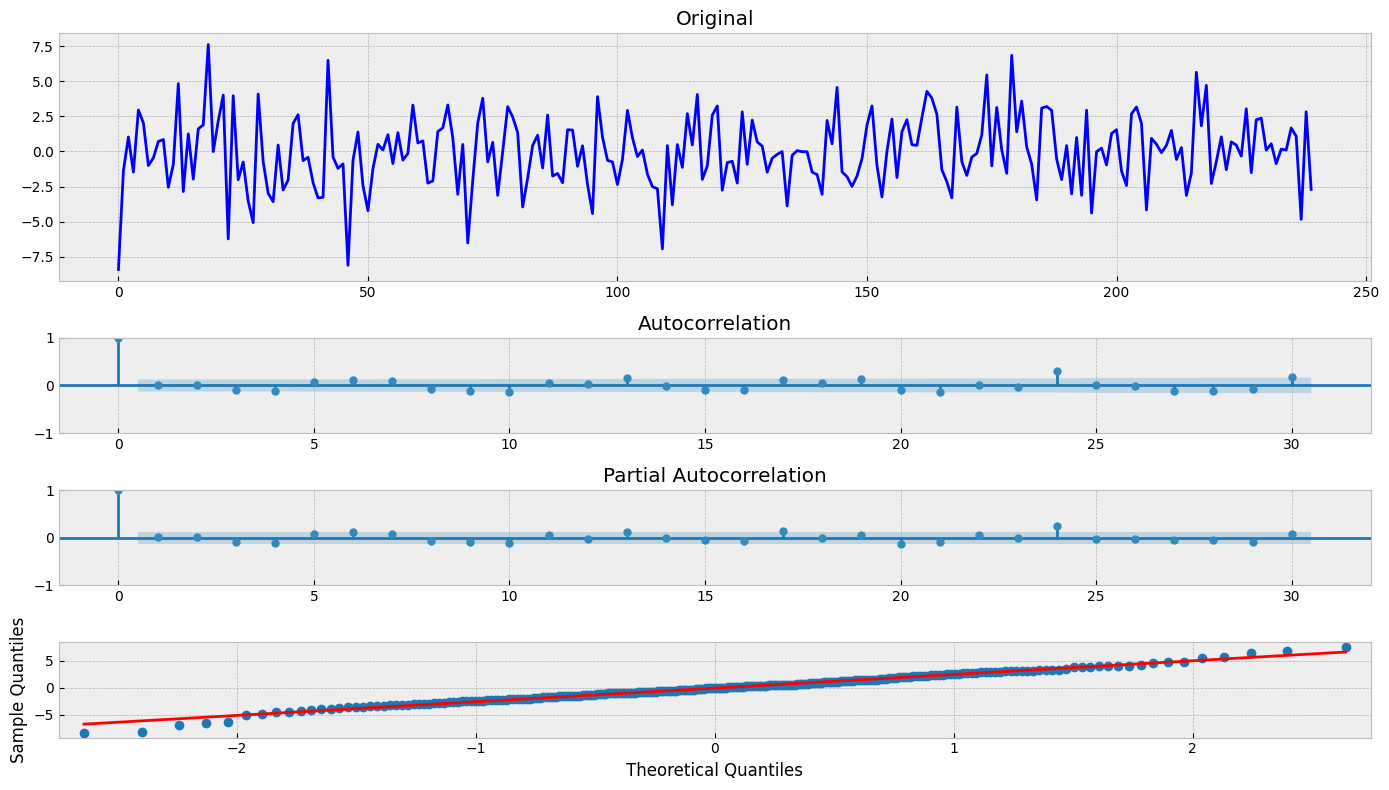

In [127]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                model = sm.tsa.arima.ARIMA(series, order=(i,d,j))
                tmp_mdl = model.fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

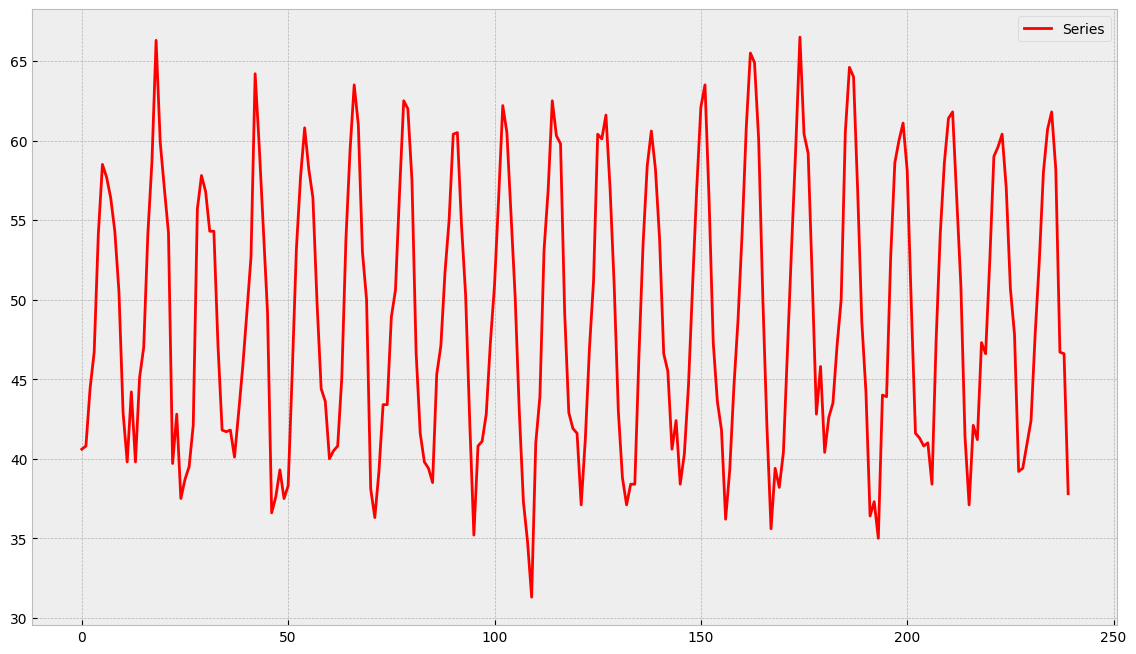

In [128]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

#### Теперь модель ARIMA отработала хорошо: прогноз похож на фактические данные, использованные для обучения, при этом находится в доверительном интервале (95%). 
#### Вывод -> модель ARIMA не требует предварительного приведения ряда к стационарности.